# Skin cancer classification

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from PIL import Image
from scipy.signal import convolve2d

## Pipeline dasar

1. Akuisisi data
2. Preprocessing (Normalisasi, mengurangi noise)
3. Segmentasi (Memisahkan area lesi dari kulit sehat)
4. Ekstraksi fitur (Warna, tekstur, bentuk)
5. Seleksi fitur
6. Feature matching



### Akuisisi data

Dataset yang digunakan adalah ISIC 2016 Challenge Dataset Task 3 yang berisi citra kulit dengan lesi jinak (benign) dan ganas (malignant). Dataset ini dapat diunduh dari [situs resmi ISIC](https://challenge.isic-archive.com/data/).

### Preprocessing

Pada tahap preprocessing, kita akan melakukan beberapa langkah berikut:
1. **Normalisasi**: Menyesuaikan intensitas warna pada citra untuk mengurangi variasi pencahayaan.
2. **Pengurangan noise**: Menggunakan filter seperti Gaussian atau Median untuk mengurangi noise pada gambar.

In [3]:
import os
print(os.getcwd())

d:\2 Kuliah\S2 - Universitas Gadjah Mada\Semester 1\RPP\Tugas\tugas_proyek_akhir


In [4]:
# Lihat satu citra untuk masing-masing kelas
# benign: Dataset\ISBI2016_ISIC_Part3_Training_Data\ISIC_0000000.jpg
# malignant: Dataset\ISBI2016_ISIC_Part3_Training_Data\ISIC_0000002.jpg
img_benign = Image.open(Path("./Dataset/ISBI2016_ISIC_Part3_Training_Data/ISIC_0000000.jpg"))
img_malignant = Image.open(Path("./Dataset/ISBI2016_ISIC_Part3_Training_Data/ISIC_0000002.jpg"))

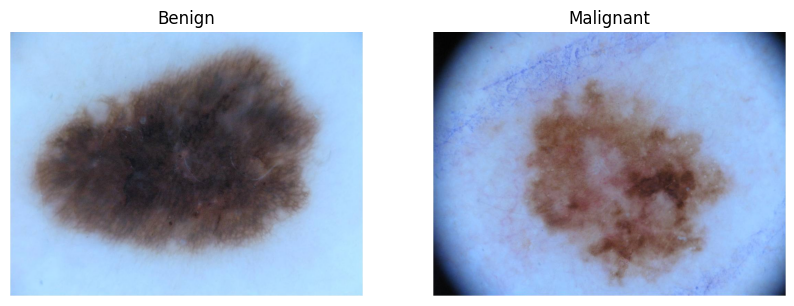

In [5]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img_benign)
plt.title("Benign")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(img_malignant)
plt.title("Malignant")
plt.axis("off")

plt.show()

Dapat dilihat bahwa pada citra kulit memiliki foreground yang merupakan area lesi dan background yang merupakan kulit sehat.

#### Noice reduction

Noice reduction dapat dilakukan dengan menggunakan beberapa metode, di antaranya:
- Gaussian Filter
- Median Filter
- Bilateral Filter

Pada tahap ini, kita akan menggunakan Gaussian Filter untuk mengurangi noise pada citra kulit.

In [6]:
def gaussian_kernel(ksize=5, sigma=1.0):
    """
    Membuat kernel Gaussian 2D.
    ksize: ukuran kernel (ganjil, misal 3,5,7,...)
    sigma: standar deviasi Gaussian
    """
    ax = np.arange(-ksize//2 + 1, ksize//2 + 1)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    kernel = kernel / np.sum(kernel)   # normalisasi
    return kernel

def gaussian_filter(img, ksize=5, sigma=1.0):
    """
    Gaussian filter untuk noise reduction.
    img: citra numpy array (grayscale atau RGB)
    """
    kernel = gaussian_kernel(ksize, sigma)

    if img.ndim == 2:  # grayscale
        return convolve2d(img, kernel, mode='same', boundary='symm')

    elif img.ndim == 3:  # RGB
        filtered = np.zeros_like(img, dtype=float)
        for c in range(3):
            filtered[:, :, c] = convolve2d(img[:, :, c], kernel, mode='same', boundary='symm')
        return filtered

    else:
        raise ValueError("Format citra tidak dikenali.")    

img_benign_arr = np.array(img_benign)
img_malignant_arr = np.array(img_malignant)

img_benign_filtered = gaussian_filter(img_benign_arr)
img_malignant_filtered = gaussian_filter(img_malignant_arr)


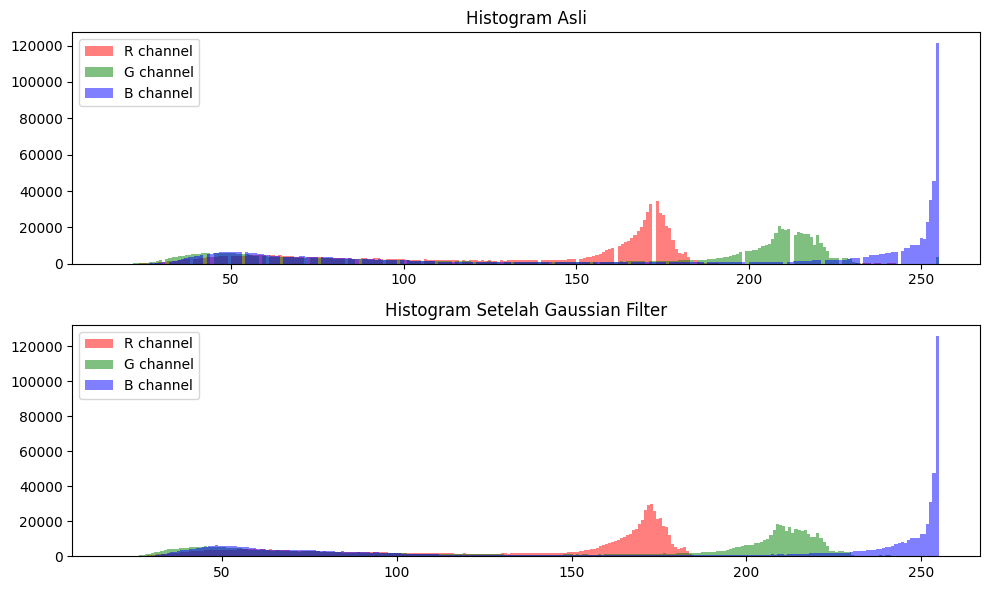

In [7]:
# --- Plot histogram sebelum dan sesudah filtering ---
fig, axes = plt.subplots(2, 1, figsize=(10,6))

colors = ['r','g','b']

# Histogram asli
for i, color in enumerate(colors):
    axes[0].hist(img_benign_arr[:,:,i].ravel(), bins=256, color=color, alpha=0.5, label=f'{color.upper()} channel')
axes[0].set_title('Histogram Asli')
axes[0].legend()

# Histogram setelah Gaussian filter
for i, color in enumerate(colors):
    axes[1].hist(img_benign_filtered[:,:,i].ravel(), bins=256, color=color, alpha=0.5, label=f'{color.upper()} channel')
axes[1].set_title('Histogram Setelah Gaussian Filter')
axes[1].legend()

plt.tight_layout()
plt.show()

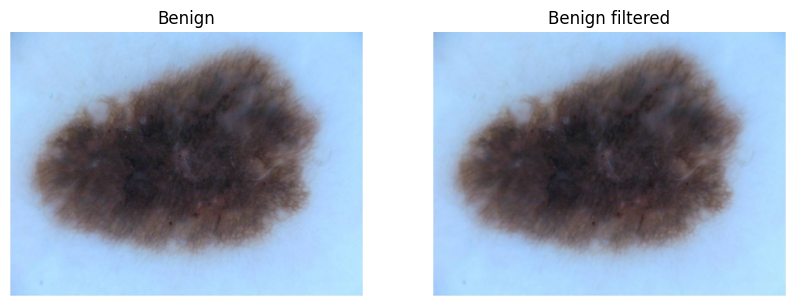

In [8]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img_benign)
plt.title("Benign")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(img_benign_filtered.astype(np.uint8))
plt.title("Benign filtered")
plt.axis("off")

plt.show()

In [9]:
import cv2
import numpy as np

# 1. Load citra asli
img_original = cv2.imread("hasil fiter", img_benign_filtered.astype(np.uint8)) # Ini masih RGB/BGR

# 2. Proses mendapatkan mask
img_gray = cv2.cvtColor(img_original, cv2.COLOR_BGR2GRAY)
_, mask_otsu = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# --- INI BAGIAN PENTINGNYA ---
# 3. Terapkan mask ke citra asli menggunakan operasi Bitwise AND
# Logikanya: Ambil pixel dari img_original HANYA JIKA mask_otsu bernilai 'putih'
hasil_segmentasi_berwarna = cv2.bitwise_and(img_original, img_original, mask=mask_otsu)

# Sekarang 'hasil_segmentasi_berwarna' isinya adalah lesi dengan warna asli,
# sedangkan backgroundnya hitam pekat (0,0,0).

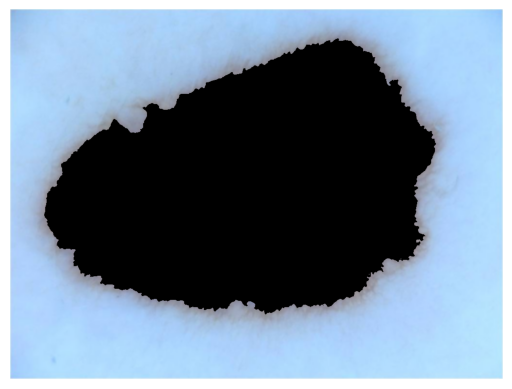

In [10]:
plt.imshow(hasil_segmentasi_berwarna)
plt.axis("off")
plt.show()

In [11]:
kernel = np.ones((19,19), np.uint8) # Ukuran kernel menentukan seberapa tebal pelebarannya
mask_dilated = cv2.dilate(mask_otsu, kernel, iterations=1)

In [12]:
hasil_segmentasi_berwarna_dilated = cv2.bitwise_and(img_original, img_original, mask=mask_dilated)

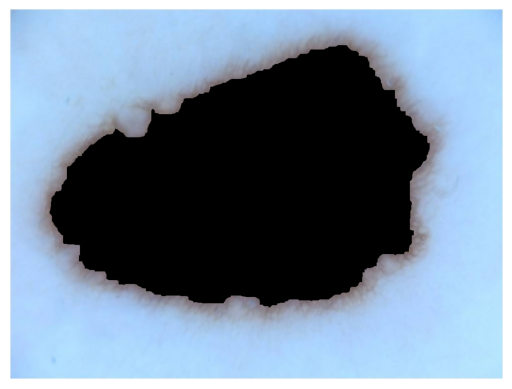

In [13]:
plt.imshow(hasil_segmentasi_berwarna_dilated)
plt.axis("off")
plt.show()

In [14]:
# Ubah ke HSV
hsv = cv2.cvtColor(img_benign_filtered.astype(np.uint8), cv2.COLOR_BGR2HSV)

# Ambil channel S saja (index 1)
s_channel = hsv[:, :, 1]

# Otsu pada S-channel ini
_, mask_s = cv2.threshold(s_channel, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

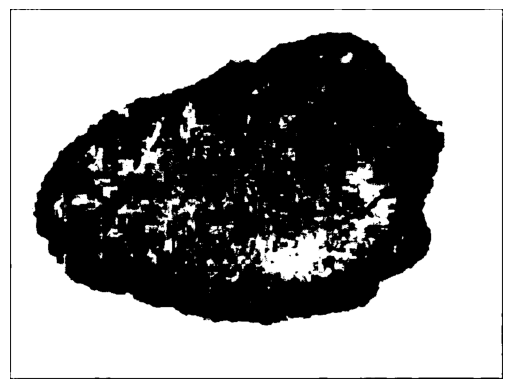

In [15]:
plt.imshow(mask_s, cmap="gray")
plt.axis("off")
plt.show()

In [16]:
# Invert
mask_s_inverted = cv2.bitwise_not(mask_s)

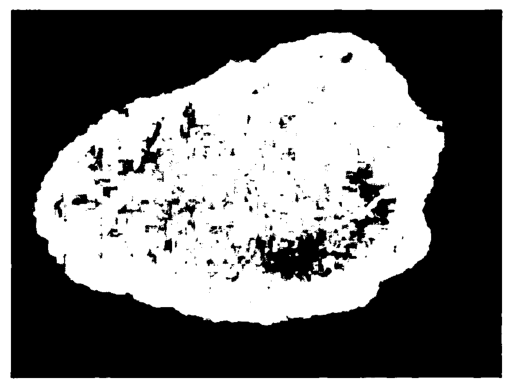

In [17]:
plt.imshow(mask_s_inverted, cmap="gray")
plt.axis("off")
plt.show()

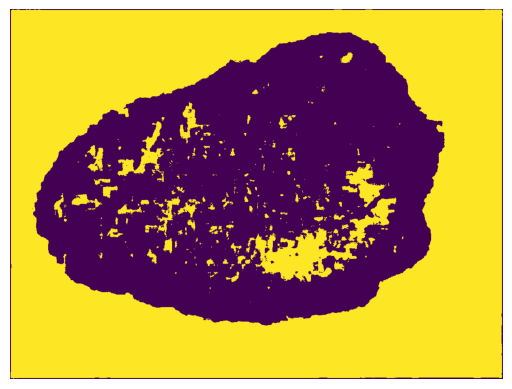

In [18]:
plt.imshow(mask_s)
plt.axis("off")
plt.show()

In [19]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (19,19))
mask_s_inverted_dilated = cv2.dilate(mask_s_inverted, kernel, iterations=2)

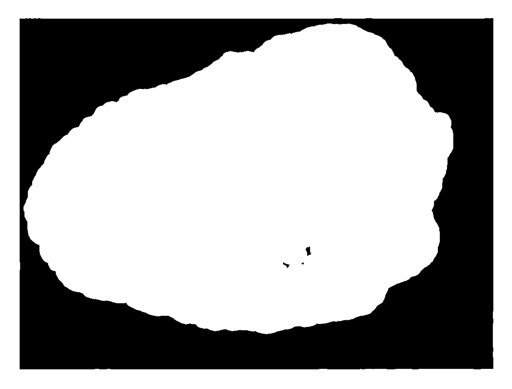

In [20]:
plt.imshow(mask_s_inverted_dilated, cmap="gray")
plt.axis("off")
plt.show()

In [21]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (19,19))

mask_s_closed = cv2.morphologyEx(mask_s_inverted, cv2.MORPH_CLOSE, kernel, iterations=2)

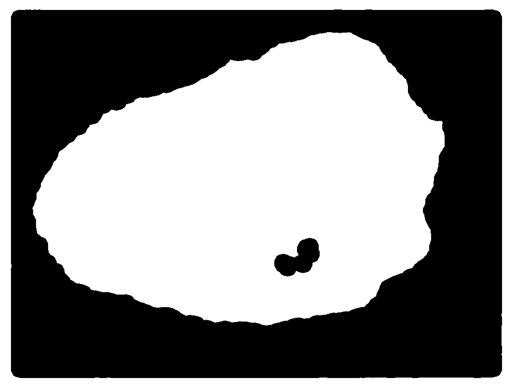

In [22]:
plt.imshow(mask_s_closed, cmap="gray")
plt.axis("off")
plt.show()

Jumlah kontur terdeteksi setelah border dibersihkan: 1


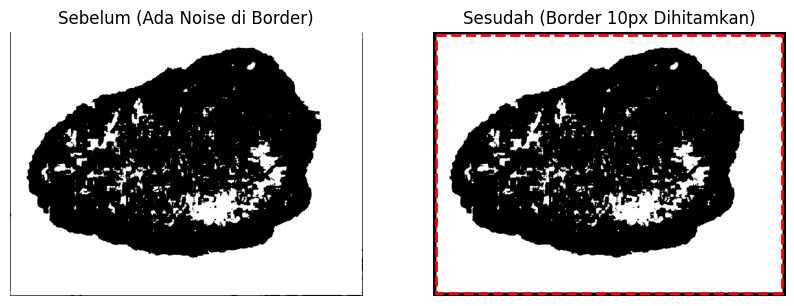

In [23]:
# 1. Tentukan ketebalan border yang ingin dihapus (misal 5-10 pixel)
margin = 10 

# 2. Buat copy gambar agar gambar asli tidak terganti (opsional)
mask_cleaned = mask_s.copy()

# 3. Dapatkan dimensi gambar (Tinggi, Lebar)
h, w = mask_cleaned.shape[:2]

# --- Proses Menghitamkan Border ---

# Set border ATAS jadi hitam
# (Dari baris 0 sampai baris ke-'margin', selebar gambar)
mask_cleaned[0:margin, :] = 0

# Set border BAWAH jadi hitam
# (Dari tinggi minus 'margin' sampai habis, selebar gambar)
mask_cleaned[h-margin:h, :] = 0

# Set border KIRI jadi hitam
# (Sepanjang tinggi gambar, dari kolom 0 sampai 'margin')
mask_cleaned[:, 0:margin] = 0

# Set border KANAN jadi hitam
# (Sepanjang tinggi gambar, dari lebar minus 'margin' sampai habis)
mask_cleaned[:, w-margin:w] = 0

# --- Sekarang 'mask_cleaned' aman untuk findContours ---
contours, _ = cv2.findContours(mask_cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

print(f"Jumlah kontur terdeteksi setelah border dibersihkan: {len(contours)}")

# --- Visualisasi ---
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Sebelum (Ada Noise di Border)")
plt.imshow(mask_s, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title(f"Sesudah (Border {margin}px Dihitamkan)")
plt.imshow(mask_cleaned, cmap='gray')
# Saya gambar kotak merah untuk menunjukkan area yang kita hitamkan paksa
plt.gca().add_patch(plt.Rectangle((margin, margin), w-2*margin, h-2*margin, 
                                  edgecolor='red', facecolor='none', lw=2, ls='--'))
plt.axis('off')

plt.show()

Skipping frame contour (Area: 782086.0)
Tidak ada objek yang ditemukan selain bingkai!


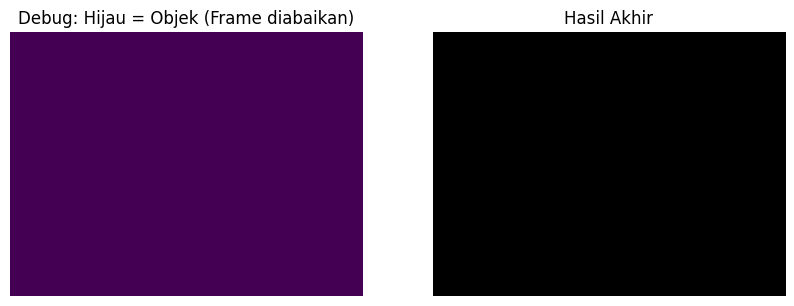

In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load gambar (pastikan mode grayscale)
# Ganti dengan path gambar kamu yang terakhir

# 1. PRE-PROCESSING PENTING:
# Karena input di gambar kamu Objek=Hitam, BG=Putih, kita harus BALIK dulu.
# OpenCV Wajib: Objek = Putih (255), Background = Hitam (0)

thresh_obj_white = cv2.bitwise_not(mask_s)

# Pastikan biner murni
_, thresh_obj_white = cv2.threshold(thresh_obj_white, 127, 255, cv2.THRESH_BINARY)

# 2. Temukan kontur
contours, _ = cv2.findContours(thresh_obj_white, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 3. LOGIKA BARU: Filter Kontur Bingkai
h, w = mask_s.shape[:2]
image_area = h * w
target_contour = None

# Urutkan kontur dari yang paling besar ke kecil
sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)

for c in sorted_contours:
    area = cv2.contourArea(c)
    
    # Syarat: Jika area kontur > 90% total gambar, itu pasti bingkai (border luar)
    # Kita skip (continue) dan cek kontur terbesar berikutnya
    if area > (image_area * 0.90):
        print(f"Skipping frame contour (Area: {area})")
        continue
    
    # Jika lolos filter di atas, berarti ini adalah OBJEK UTAMA kita
    target_contour = c
    print(f"Object found! (Area: {area})")
    break

# 4. Gambar Ulang (Filling)
result = np.zeros_like(thresh_obj_white)

if target_contour is not None:
    # Gambar isian penuh
    cv2.drawContours(result, [target_contour], -1, 255, thickness=cv2.FILLED)
    
    # --- DEBUG VISUALIZATION (Opsional) ---
    debug_img = cv2.cvtColor(thresh_obj_white, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(debug_img, [target_contour], -1, (0, 255, 0), 5) # Gambar hijau tebal
else:
    print("Tidak ada objek yang ditemukan selain bingkai!")
    debug_img = np.zeros_like(thresh_obj_white)

# Tampilkan
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Debug: Hijau = Objek (Frame diabaikan)")
plt.imshow(debug_img)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Hasil Akhir")
plt.imshow(result, cmap='gray')
plt.axis('off')
plt.show()

Sukses! Kontur terbesar dengan luas 367964.0 pixel telah diisi.


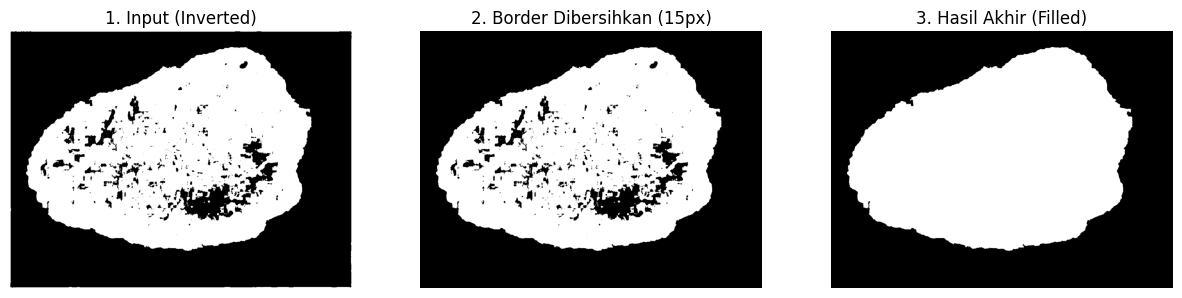

In [25]:
# --- 1. Persiapan Input (Simulasi kondisi kamu) ---
# Asumsi 'mask_s' adalah hasil thresholding kamu yang masih berlubang & border berantakan
# (Saya load gambar contoh dan memastikan formatnya biner 1 channel)
img_asli = mask_s
_, mask_s = cv2.threshold(img_asli, 127, 255, cv2.THRESH_BINARY)

# --- 2. Perbaiki Polaritas (Invert) ---
# Karena input kamu background putih & objek hitam, kita balik dulu.
# Target: Objek = PUTIH (255), Background = HITAM (0)
mask_white_obj = cv2.bitwise_not(mask_s)

# --- 3. Bersihkan Border (Crop/Masking Manual) ---
# Kita timpa pinggiran gambar dengan warna hitam (0) agar tidak mengganggu deteksi kontur
h, w = mask_white_obj.shape
margin = 15  # Atur ketebalan border yang mau dihapus (pixel)

# Copy agar aman
mask_clean = mask_white_obj.copy()
mask_clean[0:margin, :] = 0      # Atas
mask_clean[h-margin:h, :] = 0    # Bawah
mask_clean[:, 0:margin] = 0      # Kiri
mask_clean[:, w-margin:w] = 0    # Kanan

# --- 4. Cari Kontur Terluar ---
# RETR_EXTERNAL = Kunci ajaib! Dia mengabaikan lubang di dalam objek.
contours, _ = cv2.findContours(mask_clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Siapkan kanvas kosong untuk hasil akhir
final_result = np.zeros_like(mask_clean)

if len(contours) > 0:
    # Ambil kontur terbesar (berdasarkan area) untuk membuang noise kecil (jika ada)
    c_max = max(contours, key=cv2.contourArea)
    
    # --- 5. Gambar Ulang dengan Isian Penuh ---
    # thickness = -1 (atau cv2.FILLED) artinya "warnai isinya sampai penuh"
    cv2.drawContours(final_result, [c_max], -1, 255, thickness=cv2.FILLED)
    
    print(f"Sukses! Kontur terbesar dengan luas {cv2.contourArea(c_max)} pixel telah diisi.")
else:
    print("Error: Tidak ada kontur yang ditemukan setelah border dibersihkan.")

# --- Visualisasi Proses ---
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("1. Input (Inverted)")
plt.imshow(mask_white_obj, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title(f"2. Border Dibersihkan ({margin}px)")
plt.imshow(mask_clean, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("3. Hasil Akhir (Filled)")
plt.imshow(final_result, cmap='gray')
plt.axis('off')

plt.show()

In [26]:
final_result_inverted = cv2.bitwise_not(final_result)

hasil_segmentasi_berwarna = cv2.bitwise_and(img_original, img_original, mask=final_result)
hasil_segmentasi_berwarna_inverted = cv2.bitwise_and(img_original, img_original, mask=final_result_inverted)

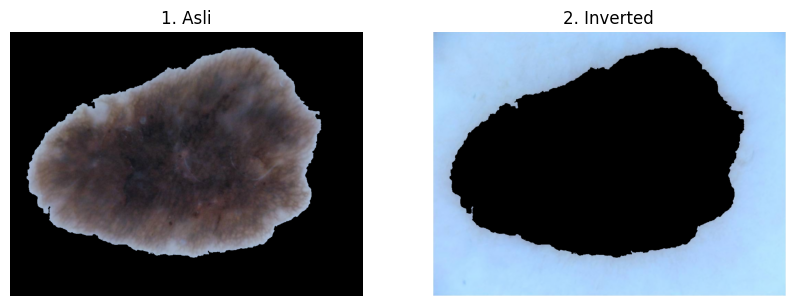

In [27]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("1. Asli")
plt.imshow(hasil_segmentasi_berwarna, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title(f"2. Inverted")
plt.imshow(hasil_segmentasi_berwarna_inverted, cmap='gray')
plt.axis('off')

plt.show()

## Ekstraksi fitur

### Asymmetri

--- Hasil Ekstraksi Fitur Asimetri ---
asymmetry_index_h: 71.7794
asymmetry_index_v: 73.3963
asymmetry_index_total: 72.5878
hu_moment_1: 0.7519
hu_moment_2: 2.3053
hog_variance: 0.0026
hog_mean: 0.0055


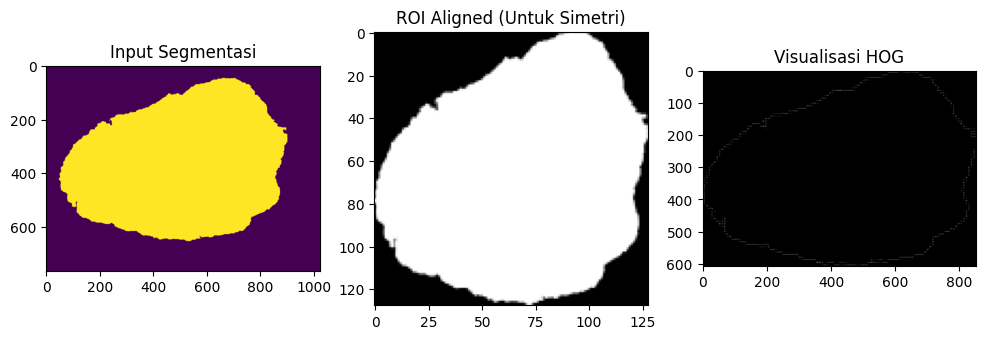

In [28]:
import cv2
import numpy as np
from skimage.feature import hog
from scipy.stats import entropy

def ekstraksi_fitur_asimetri(hasil_segmentasi):
    """
    Mengekstraksi fitur Asimetri (A) untuk deteksi Melanoma.
    
    Args:
        hasil_segmentasi (numpy.ndarray): Gambar input RGB hasil segmentasi 
                                                   (background hitam).
    
    Returns:
        dict: Dictionary berisi nilai fitur.
    """
    # 1. PREPROCESSING (YANG BENAR)
    
    # Cek jumlah dimensi array (ndim) atau panjang tuple shape
    if len(hasil_segmentasi.shape) == 2:
        # KASUS 1: Gambar sudah Grayscale (hanya punya tinggi & lebar)
        # Tidak perlu convert, langsung pakai
        gray = hasil_segmentasi
        # Opsional: Buat versi 'palsu' berwarna hanya untuk keperluan return visualisasi nanti
        hasil_segmentasi_berwarna = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
        
    else:
        # KASUS 2: Gambar Berwarna (tinggi, lebar, channel)
        hasil_segmentasi_berwarna = hasil_segmentasi
        gray = cv2.cvtColor(hasil_segmentasi, cv2.COLOR_RGB2GRAY)
    
    # Buat Mask Biner (Thresholding) - Asumsi lesi lebih terang dari background hitam
    _, mask = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
    
    # Mencari Bounding Box untuk memusatkan lesi (Penting untuk perhitungan simetri)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if not contours:
        return None # Return None jika tidak ada lesi terdeteksi
        
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)
    
    # Crop lesi (ROI - Region of Interest)
    roi = mask[y:y+h, x:x+w]
    roi_gray = gray[y:y+h, x:x+w]

    # --- FITUR 1: SIMETRI GEOMETRIS (Rotational/Mirror) ---
    # Kita perlu membuat ROI menjadi persegi agar flipping akurat secara proporsi
    # atau kita resize ke ukuran tetap (misal 128x128) untuk normalisasi
    dim = (128, 128)
    roi_resized = cv2.resize(roi, dim, interpolation=cv2.INTER_AREA)
    
    # Flip Horizontal & Vertikal
    flip_h = cv2.flip(roi_resized, 1) # 1 = Horizontal
    flip_v = cv2.flip(roi_resized, 0) # 0 = Vertikal
    
    # Hitung perbedaan (XOR atau Abs Diff)
    # Semakin tinggi nilainya, semakin asimetris
    diff_h = cv2.absdiff(roi_resized, flip_h)
    diff_v = cv2.absdiff(roi_resized, flip_v)
    
    # Normalisasi score berdasarkan luas area agar invarian terhadap skala
    area_pixels = cv2.countNonZero(roi_resized) + 1e-5 # avoid div by zero
    asymmetry_score_h = np.sum(diff_h) / area_pixels
    asymmetry_score_v = np.sum(diff_v) / area_pixels
    total_asymmetry_index = (asymmetry_score_h + asymmetry_score_v) / 2

    # --- FITUR 2: HU MOMENTS (Shape Moments) ---
    # Dihitung pada mask biner asli (sebelum resize) untuk presisi
    moments = cv2.moments(largest_contour)
    hu_moments = cv2.HuMoments(moments).flatten()
    
    # Log transform agar range angka tidak terlalu jauh (biasanya output Hu sangat kecil)
    # Menggunakan -1 * copysign(1.0, x) * log10(abs(x))
    hu_moments_log = [-1 * np.sign(h) * np.log10(np.abs(h)) if h != 0 else 0 for h in hu_moments]

    # --- FITUR 3: HOG (Histogram of Oriented Gradients) ---
    # HOG menangkap arah gradien dominan (tekstur tepi)
    # pixels_per_cell menentukan seberapa detail grid-nya
    hog_features, hog_image = hog(roi_gray, orientations=9, pixels_per_cell=(8, 8),
                                  cells_per_block=(2, 2), visualize=True, channel_axis=None)
    
    # Analisis HOG:
    # Jika melanoma asimetris struktural, distribusi gradiennya akan "kacau" (entropy tinggi/variance tinggi).
    # Jika jinak, mungkin lebih halus atau seragam.
    hog_mean = np.mean(hog_features)
    hog_variance = np.var(hog_features) # Indikasi seberapa bervariasi arah tepinya
    
    # Menyusun hasil
    features = {
        "asymmetry_index_h": asymmetry_score_h,
        "asymmetry_index_v": asymmetry_score_v,
        "asymmetry_index_total": total_asymmetry_index,
        "hu_moment_1": hu_moments_log[0], # Hu Moment pertama biasanya tentang momen inersia
        "hu_moment_2": hu_moments_log[1],
        "hog_variance": hog_variance,     # Indikator "kekacauan" orientasi
        "hog_mean": hog_mean
    }
    
    return features, roi_resized, hog_image

# Eksekusi fungsi
fitur, visual_roi, visual_hog = ekstraksi_fitur_asimetri(final_result)

print("--- Hasil Ekstraksi Fitur Asimetri ---")
for key, value in fitur.items():
    print(f"{key}: {value:.4f}")

# Visualisasi (Opsional)
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(final_result)
ax[0].set_title("Input Segmentasi")
ax[1].imshow(visual_roi, cmap='gray')
ax[1].set_title("ROI Aligned (Untuk Simetri)")
ax[2].imshow(visual_hog, cmap='gray')
ax[2].set_title("Visualisasi HOG")
plt.show()

--- Fitur Border Irregularity ---
border_solidity: 0.9623
border_convexity: 0.7863
border_roughness: 0.1620
fractal_dimension: 1.3218


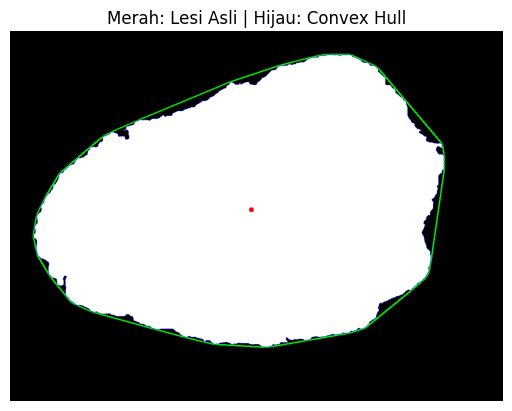

In [29]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

def fractal_dimension(image_binary, threshold=0.9):
    """
    Menghitung Fractal Dimension (Box Counting Method) pada gambar biner (hanya tepinya).
    """
    # Pastikan input adalah boolean/biner
    Z = (image_binary > 0)

    # Minimal dimensi
    p = min(Z.shape)

    # Greatest power of 2 less than or equal to p
    n = 2**np.floor(np.log(p)/np.log(2))
    n = int(np.log(n)/np.log(2))

    # Build successive box sizes (scales)
    sizes = 2**np.arange(n, 1, -1)

    # Actual box counting with decreasing size
    counts = []
    for size in sizes:
        # Potong gambar agar habis dibagi ukuran box (truncate)
        s2 = size
        h_lim = Z.shape[0] // s2 * s2
        w_lim = Z.shape[1] // s2 * s2
        Z_trim = Z[:h_lim, :w_lim]
        
        # Reshape menjadi blok-blok 2D dan cek apakah ada pixel (any)
        # (Technique: strided reshaping for efficient block processing)
        blocks = (Z_trim.reshape(Z_trim.shape[0]//s2, s2,
                                 Z_trim.shape[1]//s2, s2).sum(axis=(1, 3)) > 0)
        counts.append(np.sum(blocks))

    # Fit linear regression: log(counts) vs log(1/sizes)
    # Slope (kemiringan) adalah Fractal Dimension
    coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
    return -coeffs[0] # Negatif karena x-axis adalah log(size), bukan log(1/size)

def ekstraksi_fitur_border(hasil_segmentasi):
    """
    Mengekstraksi fitur Border Irregularity (B).
    Input: Gambar Mask Biner atau Grayscale
    """
    
    # --- 1. PREPROCESSING (Ambil Contour Terbesar) ---
    if len(hasil_segmentasi.shape) == 3:
        gray = cv2.cvtColor(hasil_segmentasi, cv2.COLOR_RGB2GRAY)
    else:
        gray = hasil_segmentasi
        
    _, mask = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if not contours:
        return None, None
        
    cnt = max(contours, key=cv2.contourArea)
    
    # --- 2. SOLIDITY & CONVEXITY ---
    # Convex Hull: Bentuk cembung imajiner yang membungkus lesi (seperti karet gelang)
    hull = cv2.convexHull(cnt)
    
    area_contour = cv2.contourArea(cnt)
    area_hull = cv2.contourArea(hull)
    
    perimeter_contour = cv2.arcLength(cnt, True)
    perimeter_hull = cv2.arcLength(hull, True)
    
    # Solidity: Seberapa "penuh" area hull terisi oleh lesi
    # Nilai rendah = Tepi banyak lekukan dalam (concave)
    solidity = float(area_contour) / area_hull if area_hull > 0 else 0
    
    # Convexity: Perbandingan keliling
    # Nilai rendah = Tepi sangat bergerigi (keliling lesi jauh lebih panjang dari hull)
    convexity = float(perimeter_hull) / perimeter_contour if perimeter_contour > 0 else 0

    # --- 3. CONTOUR ROUGHNESS (Radial Distance Variance) ---
    # Hitung centroid (titik pusat massa)
    M = cv2.moments(cnt)
    if M['m00'] != 0:
        cx = int(M['m10'] / M['m00'])
        cy = int(M['m01'] / M['m00'])
    else:
        cx, cy = 0, 0
        
    # Hitung jarak setiap titik di contour ke centroid
    distances = []
    for point in cnt:
        px, py = point[0]
        dist = np.sqrt((px - cx)**2 + (py - cy)**2)
        distances.append(dist)
        
    distances = np.array(distances)
    mean_dist = np.mean(distances)
    std_dist = np.std(distances)
    
    # Normalized roughness (Coefficient of Variation)
    # Agar tidak terpengaruh ukuran gambar (invariant to scale)
    roughness_index = std_dist / mean_dist if mean_dist > 0 else 0

    # --- 4. FRACTAL DIMENSION ---
    # Kita butuh gambar yang HANYA berisi garis tepi (edge only) setebal 1 pixel
    edge_canvas = np.zeros_like(mask)
    cv2.drawContours(edge_canvas, [cnt], -1, 255, 1) # Tebal 1 px
    
    fd_score = fractal_dimension(edge_canvas)

    features = {
        "border_solidity": solidity,       # < 1 indikasi irregular
        "border_convexity": convexity,     # < 1 indikasi irregular
        "border_roughness": roughness_index, # Tinggi = irregular
        "fractal_dimension": fd_score      # Tinggi = kompleks/kasar (biasanya 1.0 - 2.0)
    }
    
    # Return visualisasi Convex Hull untuk debug
    visual_hull = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(visual_hull, [hull], -1, (0, 255, 0), 2) # Garis Hijau = Hull
    cv2.drawContours(visual_hull, [cnt], -1, (0, 0, 255), 1)  # Garis Merah = Lesi Asli
    # Gambar Centroid
    cv2.circle(visual_hull, (cx, cy), 5, (255, 0, 0), -1)

    return features, visual_hull

fitur_b, vis_b = ekstraksi_fitur_border(final_result)

print("--- Fitur Border Irregularity ---")
for k, v in fitur_b.items():
    print(f"{k}: {v:.4f}")

plt.imshow(vis_b)
plt.title("Merah: Lesi Asli | Hijau: Convex Hull")
plt.axis('off')
plt.show()

--- Fitur Color Variegation ---
std_R: 36.7734
std_G: 40.3963
std_B: 4.3234
std_H: 58.2675
std_S: 14.1122
std_V: 43.1328
mean_L: 86.8414
std_L: 42.2233
std_A: 2.3657
entropy_L: 4.9549
color_cluster_spread: 117.5865
ratio_dark_area: 0.0854
ratio_white_area: 0.0000
ratio_blue_area: 0.0000


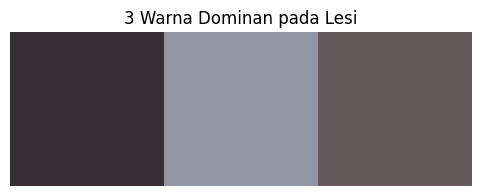

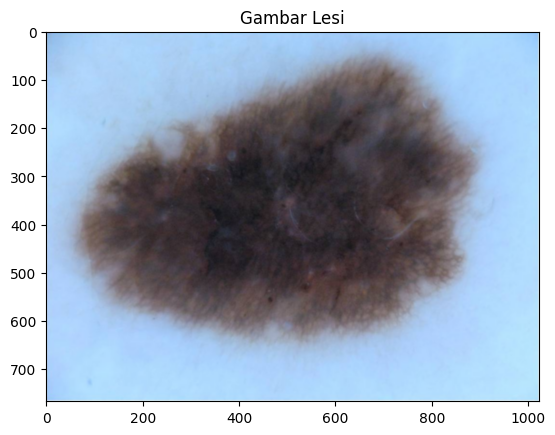

In [30]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy
from sklearn.cluster import KMeans

def ekstraksi_fitur_warna(img_asli, mask):
    """
    Mengekstraksi fitur Color Variegation (C).
    
    Args:
        img_asli (numpy.ndarray): Gambar asli berwarna (RGB).
        mask (numpy.ndarray): Masker biner hasil segmentasi (0 dan 255/1).
        
    Returns:
        dict: Fitur statistik warna.
        list: Center warna dominan (untuk visualisasi).
    """
    
    # --- 1. PREPROCESSING & MASKING ---
    # Pastikan mask adalah biner boolean
    if len(mask.shape) == 3:
        mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
    _, mask_bin = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    
    # Ambil HANYA piksel di dalam lesi (Flattening)
    # Kita tidak memakai gambar kotak, tapi list memanjang dari piksel yang valid
    # pixels_rgb shape: (N_pixels, 3)
    pixels_rgb = img_asli[mask_bin > 0]
    
    if len(pixels_rgb) == 0:
        return None, None

    # Konversi ke ruang warna lain untuk piksel yang valid saja
    # Kita perlu reshape ke (N, 1, 3) untuk cvtColor, lalu flatten lagi
    pixels_rgb_r = pixels_rgb.reshape(-1, 1, 3)
    
    pixels_hsv = cv2.cvtColor(pixels_rgb_r, cv2.COLOR_RGB2HSV).reshape(-1, 3)
    pixels_lab = cv2.cvtColor(pixels_rgb_r, cv2.COLOR_RGB2LAB).reshape(-1, 3)

    features = {}

    # --- 2. STATISTIK CHANNEL (Variance & Mean) ---
    # Semakin tinggi Std Dev, semakin bervariasi warnanya (Color Variegation)
    
    # RGB Stats
    features['std_R'] = np.std(pixels_rgb[:, 0])
    features['std_G'] = np.std(pixels_rgb[:, 1])
    features['std_B'] = np.std(pixels_rgb[:, 2])
    
    # HSV Stats (Hue, Saturation, Value)
    features['std_H'] = np.std(pixels_hsv[:, 0])
    features['std_S'] = np.std(pixels_hsv[:, 1]) # Variasi kepudaran warna
    features['std_V'] = np.std(pixels_hsv[:, 2]) # Variasi kecerahan (gelap/terang)
    
    # LAB Stats (L=Lightness, A=Green-Red, B=Blue-Yellow)
    # LAB sangat bagus untuk mendeteksi warna kemerahan vs kebiruan
    features['mean_L'] = np.mean(pixels_lab[:, 0])
    features['std_L'] = np.std(pixels_lab[:, 0])
    features['std_A'] = np.std(pixels_lab[:, 1])
    features['std_B'] = np.std(pixels_lab[:, 2])

    # --- 3. ENTROPY (Keteracakan Warna) ---
    # Kita hitung histogram intensitas (L channel) lalu hitung entropinya
    # Entropy tinggi = Tekstur/warna sangat acak (khas melanoma)
    hist_L, _ = np.histogram(pixels_lab[:, 0], bins=256, range=(0, 256), density=True)
    features['entropy_L'] = entropy(hist_L + 1e-7) # +epsilon biar tidak log(0)

    # --- 4. COLOR CLUSTERING (K-Means) ---
    # Mengukur heterogenitas dengan mencoba mengelompokkan warna
    # Kita cari 3 warna dominan
    kmeans = KMeans(n_clusters=3, random_state=42, n_init=5)
    
    # Subsampling jika piksel terlalu banyak agar cepat
    sample_pixels = pixels_rgb if len(pixels_rgb) < 5000 else pixels_rgb[::5]
    kmeans.fit(sample_pixels)
    
    dominant_colors = kmeans.cluster_centers_ # RGB centroids
    
    # Hitung jarak rata-rata antar cluster center
    # Jika jaraknya jauh, berarti ada warna yang sangat kontras (misal Coklat vs Putih vs Biru)
    # Jika dekat, berarti warnanya mirip-mirip (monokrom)
    dist_1_2 = np.linalg.norm(dominant_colors[0] - dominant_colors[1])
    dist_1_3 = np.linalg.norm(dominant_colors[0] - dominant_colors[2])
    dist_2_3 = np.linalg.norm(dominant_colors[1] - dominant_colors[2])
    features['color_cluster_spread'] = (dist_1_2 + dist_1_3 + dist_2_3) / 3

    # --- 5. DETEKSI WARNA EKSTREM (Ratios) ---
    # Ambang batas empiris (perlu disesuaikan dengan kalibrasi kamera)
    # L range di OpenCV LAB biasanya 0-255
    
    total_pix = len(pixels_lab)
    
    # Gelap pekat (Dark Black/Brown) -> L sangat rendah
    ratio_dark = np.sum(pixels_lab[:, 0] < 40) / total_pix
    
    # Putih terang (White Veil/Regression) -> L sangat tinggi
    ratio_white = np.sum(pixels_lab[:, 0] > 200) / total_pix
    
    # Blue-Gray Veil (Area sulit, biasanya L sedang, B channel rendah/negatif)
    # Di OpenCV LAB, A dan B offset +128. Jadi netral ~128. Biru itu B < 128.
    # Kita cari area yang agak gelap tapi kebiruan.
    mask_blue = (pixels_lab[:, 0] > 40) & (pixels_lab[:, 0] < 150) & (pixels_lab[:, 2] < 110)
    ratio_blue = np.sum(mask_blue) / total_pix

    features['ratio_dark_area'] = ratio_dark
    features['ratio_white_area'] = ratio_white
    features['ratio_blue_area'] = ratio_blue

    return features, dominant_colors

# Eksekusi
fitur_c, palet_warna = ekstraksi_fitur_warna(img_original, final_result)

print("--- Fitur Color Variegation ---")
for k, v in fitur_c.items():
    print(f"{k}: {v:.4f}")

# Visualisasi Palet Warna Dominan
plt.figure(figsize=(6, 2))
plt.title("3 Warna Dominan pada Lesi")
plt.imshow([palet_warna.astype(np.uint8)])
plt.axis('off')
plt.show()

# Tampilkan gambar asli
plt.imshow(img_original)
plt.title("Gambar Lesi")
plt.show()

--- Fitur Ukuran & Diameter ---
area_px2: 367964.0000
perimeter_px: 2935.8115
max_diameter_px: 870.6557
equivalent_diameter_px: 684.4752
aspect_ratio: 1.4030
bounding_box_occupancy: 0.7095


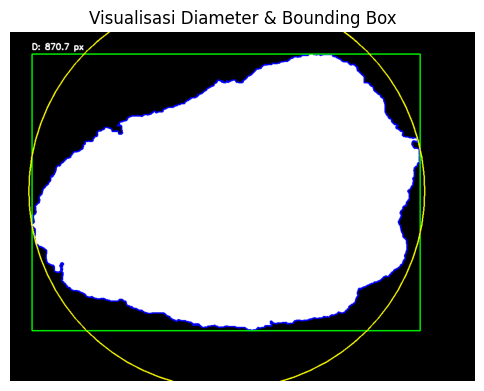

In [31]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def ekstraksi_fitur_diameter(mask, pixels_per_mm=None):
    """
    Mengekstraksi fitur Diameter dan Geometri Ukuran (D).
    
    Args:
        mask (numpy.ndarray): Masker biner atau grayscale hasil segmentasi.
        pixels_per_mm (float, optional): Faktor konversi piksel ke milimeter. 
                                         Jika None, output dalam satuan piksel.
    """
    
    # 1. PREPROCESSING
    if len(mask.shape) == 3:
        mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
    
    # Pastikan biner
    _, mask_bin = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    
    # Cari kontur
    contours, _ = cv2.findContours(mask_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if not contours:
        return None, None
    
    # Ambil kontur terbesar (asumsi itu lesi)
    cnt = max(contours, key=cv2.contourArea)
    
    # --- 2. PERHITUNGAN GEOMETRIS DASAR ---
    
    # a. Area (Luas dalam piksel)
    area = cv2.contourArea(cnt)
    
    # b. Perimeter (Keliling)
    perimeter = cv2.arcLength(cnt, True)
    
    # c. Bounding Box (Tegak Lurus)
    x, y, w, h = cv2.boundingRect(cnt)
    aspect_ratio = float(w) / h if h != 0 else 0
    
    # d. Equivalent Diameter
    # Diameter lingkaran yang memiliki luas sama dengan lesi
    # Area = pi * r^2  ->  Diameter = 2 * sqrt(Area / pi) -> sqrt(4 * Area / pi)
    equiv_diameter = np.sqrt(4 * area / np.pi)
    
    # e. Maximum Diameter (Menggunakan Minimum Enclosing Circle)
    # Ini mendekati "pengukuran klinis" diameter terpanjang lesi
    (cx, cy), radius = cv2.minEnclosingCircle(cnt)
    max_diameter_pixel = radius * 2
    
    # --- 3. KONVERSI KE SATUAN FISIK (mm) ---
    # Jika kita tidak punya skala, anggap 1 piksel = 1 unit
    scale = 1.0 if pixels_per_mm is None else (1.0 / pixels_per_mm)
    unit_suffix = "px" if pixels_per_mm is None else "mm"
    
    features = {
        f"area_{unit_suffix}2": area * (scale ** 2), # Area kuadrat
        f"perimeter_{unit_suffix}": perimeter * scale,
        f"max_diameter_{unit_suffix}": max_diameter_pixel * scale,
        f"equivalent_diameter_{unit_suffix}": equiv_diameter * scale,
        "aspect_ratio": aspect_ratio, # Tanpa satuan (rasio)
        "bounding_box_occupancy": area / (w * h) # Seberapa penuh lesi mengisi kotaknya
    }
    
    # --- 4. VISUALISASI ---
    visual_img = cv2.cvtColor(mask_bin, cv2.COLOR_GRAY2BGR)
    
    # Gambar Kontur (Merah)
    cv2.drawContours(visual_img, [cnt], -1, (0, 0, 255), 2)
    
    # Gambar Bounding Box (Hijau)
    cv2.rectangle(visual_img, (x, y), (x+w, y+h), (0, 255, 0), 2)
    
    # Gambar Enclosing Circle / Diameter (Biru)
    center = (int(cx), int(cy))
    cv2.circle(visual_img, center, int(radius), (255, 255, 0), 2)
    
    # Tulis Diameter di gambar
    label = f"D: {features[f'max_diameter_{unit_suffix}']:.1f} {unit_suffix}"
    cv2.putText(visual_img, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 
                0.6, (255, 255, 255), 2)
    
    return features, visual_img

# # --- TEST CODE ---

# # Buat dummy lesi lonjong (untuk melihat aspect ratio & diameter)
# mask_dummy_d = np.zeros((400, 400), dtype=np.uint8)
# # Ellipse miring
# cv2.ellipse(mask_dummy_d, (200, 200), (120, 60), 45, 0, 360, 255, -1)

# Asumsi kalibrasi (misal: gambar diambil dermatoskop di mana 100px = 1mm)
# Jika tidak tahu, set pixels_per_mm=None
kalibrasi = None 

fitur_d, vis_d = ekstraksi_fitur_diameter(final_result, pixels_per_mm=kalibrasi)

print("--- Fitur Ukuran & Diameter ---")
for k, v in fitur_d.items():
    print(f"{k}: {v:.4f}")

plt.figure(figsize=(6, 6))
plt.imshow(vis_d)
plt.title("Visualisasi Diameter & Bounding Box")
plt.axis('off')
plt.show()